# Sensitivity Analysis input vs. output
- This code, we use Grad-CAM like to analyze the sensitivity of $C_p$ and $C_L$
- $C_L$ is model.output
- $C_p$ is theinput. Here we use $C_p$ from test cases
- We focus on $t^*$ = [0, 3] to include the effect after gust

# Prepare data

## Load the data

Define the task complete.
(80000, 18)
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32]
(32,)
['case_13', 'case_20', 'case_25', 'case_28']
Done!
Done
Done!


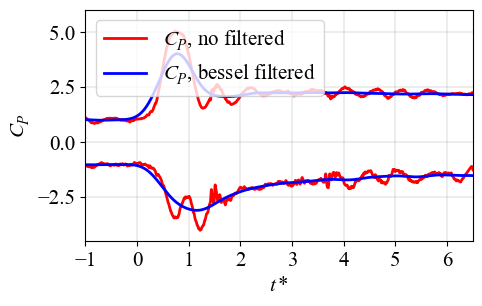

In [1]:
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

task = 'predict' 
force = 'CL'     
filt = 'bessel' 
ensemble_num = 30

if task == 'cross_validation':
    folds = 7
elif task == 'predict':
    folds = 1
else:
    print('Error. Please define your task.') 
print('Define the task complete.')

# Set the font family to Times New Roman
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 15

plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.rm'] = 'Times New Roman'
plt.rcParams['mathtext.it'] = 'Times New Roman:italic'

from keras import backend as K
import numpy as np  #Mathmatical library
import pandas as pd #for data load

import matplotlib.pyplot as plt #Plot
from tqdm import tqdm as tqdm
from scipy.signal import bessel
from scipy.signal import filtfilt

# initialize the data
history_all = {}
predictions = {}

# folder path

data_path = './train_dataframe/gust_dataframe.csv'

# read the excel data
gust_origin = pd.read_csv(data_path)

# set the first column as index, i.e. set case_nn as index, for convenience
gust_origin.set_index('case_number', inplace=True)
print(gust_origin.shape)
# check the first 5 columns
gust_origin.head()

# bessel filter for every column; only filt CP
if filt == 'bessel':
    
    gust_index   = gust_origin.index
    gust_column  = gust_origin.columns
    gust_no_filter = np.zeros((len(set(gust_index.to_list())),len(gust_origin.loc[['case_01']]),len(gust_origin.columns))) # (32,2500,18)
    gust_filter    = np.zeros((len(set(gust_index.to_list())),len(gust_origin.loc[['case_01']]),len(gust_origin.columns)))
    case_all_no = (np.linspace(0,31,32)).astype(int)
    b, a = bessel(8, 0.01) # define the bessel filter; 8 is the filter order; 0.01 is the W_n (between 0 to 1)
    
    for i in case_all_no:      # i is the case number
        case_numer = 'case_' + str(i+1).zfill(2)
        gust_no_filter[i] = gust_origin.loc[[case_numer]].to_numpy()
        for j in range(len(gust_origin.columns)-2):       # j is the CP and CL CD number
            gust_filter[i][:,j] = filtfilt(b, a, gust_no_filter[i][:,j])  # bessel for CP
        gust_filter[i][:,len(gust_origin.columns)-2] = gust_no_filter[i][:,len(gust_origin.columns)-2]  # no filter for CL
        gust_filter[i][:,len(gust_origin.columns)-1] = gust_no_filter[i][:,len(gust_origin.columns)-1]  # no filter for CD
    gust = pd.DataFrame(data=np.concatenate(gust_filter,axis=0), index=gust_index, columns=gust_column)
    
elif filt == 'no filter':
    gust = gust_origin
    
else:
    print('Error. Please define your filter.')

# check filter result

T = 0.3 # period is 0.3s
f = 1000 # frequency is 1000Hz
t_star = (np.arange(0,10000) - 500) / f / T

if filt == 'bessel':
    ii = 13 # case to show
    case_to_show = 'case_' + str(ii).zfill(2)
    cp_to_show   = [-3,-4] # -3 is p0 (stagnation point), -4 is p16(training edge point)
    fig,ax = plt.subplots(figsize=(5,3))
    ax.plot(t_star[0:2500],gust_origin.loc[[case_to_show]].to_numpy()[:,cp_to_show[0]],label='$C_{P}$, no filtered', color='red', linewidth=2)
    ax.plot(t_star[0:2500],gust_origin.loc[[case_to_show]].to_numpy()[:,cp_to_show[1]], color='red', linewidth=2)
    ax.plot(t_star[0:2500],gust.loc[[case_to_show]].to_numpy()[:,cp_to_show[0]],label='$C_{P}$, bessel filtered', color='b', linewidth=2)
    ax.plot(t_star[0:2500],gust.loc[[case_to_show]].to_numpy()[:,cp_to_show[1]], color='b', linewidth=2)
    ax.legend()
    ax.margins(x=0)
    ax.set_xlabel('$t*$')
    ax.set_xticks(np.arange(-1,8))
    ax.set_xlim(-1,6.5)
    ax.set_ylabel('$C_{P}$')
    ax.set_ylim(-4.5,6)
    ax.grid(color='k', linestyle='-', linewidth=0.1)
    
elif filt == 'no filter':
    print('No filter. No compare.')
else:
    print('Error. Please define your filter.')

# fig.savefig('CP_Filter_case_%d_port%d.png' % (ii,0), bbox_inches='tight', dpi=300)
# fig.savefig('CP_Filter_case_%d_port%d.svg' % (ii,0), bbox_inches='tight')

# retrieve CP, 16(CP) + 16(CP_1st_order) + 16(CP_2nd_order) = 48 columns in total
# simply drop CL and CD, then the rest is CP
CP = gust.drop(['CL','CD'],axis=1, inplace=False)
CP.head()

# retrieve CL and CD
CL = gust[['CL']]
CD = gust[['CD']]
gust[[force]].head()

# retrieve for 8 different folds
# read the split .txt file; the number means the cases for test
split_path = './train_dataframe/delta_wing_32cases_split_random.txt'
with open(split_path, 'r') as file1:    
    fold_split = file1.read().splitlines()       # split by \n
fold_split = fold_split[1:] # drop the head line
for i in range(8):
    fold_split[i] = fold_split[i][9:].split()    # split by space; the number starts from 10th character.
    for j in range(4):
        fold_split[i][j] = int(fold_split[i][j]) # convert string to int
fold_split

# define the 32 case number
case_all_num = np.arange(gust.index.nunique()) + 1
print(case_all_num)
print(case_all_num.shape)

# find the case number for train and test cases;
if task == 'cross_validation':
    train_case = [ [0]*24 for _ in range(folds) ] # initialize 2d list; list for 'case_nn'
    test_case  = [ [0]*4 for _ in range(folds) ]
    # find case number for cross validation folds: fold1~fold7
    for i in range(folds): 
        train_case_temp = np.setdiff1d( case_all_num, np.concatenate((fold_split[i], fold_split[-1]))) 
        # drop test case and the last one (which is for fold 8 , final test)
        test_case_temp  = fold_split[i]

        # conbine to 'case_nn' sample for train and test case; prepare for next step
        for j in range(len(train_case_temp)):
            train_case[i][j] = 'case_' + str(train_case_temp[j]).zfill(2)
        for k in range(len(test_case_temp)):
            test_case[i][k]  = 'case_' + str(test_case_temp[k]).zfill(2)
            
elif task == 'predict': 
    train_case = [ [0]*28 for _ in range(folds) ] # initialize 2d list; list for 'case_nn'
    test_case  = [ [0]*4 for _ in range(folds) ]
    # find case number for test fold: fold8  
    train_case_temp = np.setdiff1d(case_all_num, fold_split[-1])
    test_case_temp  = fold_split[-1]
    for jj in range(len(train_case_temp)):
        train_case[-1][jj] = 'case_' + str(train_case_temp[jj]).zfill(2)
    for kk in range(len(test_case_temp)):
        test_case[-1][kk]  = 'case_' + str(test_case_temp[kk]).zfill(2)

else:
    print('Error. Please define your task.')

print(test_case[0])
print('Done!')

#  prepare for train and test data sets
if task == 'cross_validation':
    F_train_rec = np.zeros([folds,60000,1]) # 24*2500 = 60000
    F_test_rec  = np.zeros([folds,10000,1])  # 4*2500  = 10000
    P_train_rec = np.zeros([folds,60000,48])
    P_test_rec  = np.zeros([folds,10000,48])

    for i in range(folds): # 7 folds for training, the last one is for test, not retrieve here, since this is for training
        if force == 'CL':
            F_train_rec[i] = CL.loc[train_case[i]].to_numpy()
            F_test_rec[i]  = CL.loc[test_case[i]].to_numpy()
        elif force == 'CD':
            F_train_rec[i] = CD.loc[train_case[i]].to_numpy()
            F_test_rec[i]  = CD.loc[test_case[i]].to_numpy()
        else:
            print('Error. Please define force.')

        P_train_rec[i] = CP.loc[train_case[i]].to_numpy()
        P_test_rec[i]  = CP.loc[test_case[i]].to_numpy()

elif task == 'predict':
    F_train_rec = np.zeros([folds,70000,1]) # 28*2500 = 70000
    F_test_rec  = np.zeros([folds,10000,1])  # 4*2500  = 10000
    P_train_rec = np.zeros([folds,70000,16])
    P_test_rec  = np.zeros([folds,10000,16])
    
    if force == 'CL':
        F_train_rec[0] = CL.loc[train_case[0]].to_numpy()
        F_test_rec[0]  = CL.loc[test_case[0]].to_numpy()
    elif force == 'CD':
        F_train_rec[0] = CD.loc[train_case[0]].to_numpy()
        F_test_rec[0]  = CD.loc[test_case[0]].to_numpy()
    else:
        print('Error. Please define force.')

    P_train_rec[0] = CP.loc[train_case[0]].to_numpy()
    P_test_rec[0]  = CP.loc[test_case[0]].to_numpy()
    
else:
    print('Error. Please define your task.')
    
print('Done')

F_train = F_train_rec[0][:,:]   # change to 2d for training
F_test  = F_test_rec[0][:,:]
P_train = P_train_rec[0][:,:]
P_test  = P_test_rec[0][:,:]

print('Done!')

## Load the model

In [2]:
from tensorflow import keras
model = keras.models.load_model('./p_filter_neuron_72_layer_8.h5')

In [3]:
model.input

<tf.Tensor 'input_30:0' shape=(None, 16) dtype=float32>

# Set the case for sensitivity analysis

In [4]:
#-- define Grad-CAM function
def grad_cam(model, input_sens): # for input

    # Get the output tensor of the model
    model_output = model.output
    # Get the input tensor of the model
    model_input = model.input # for input
    # model_input = model.get_layer(layer_name).output # for hidden layer

    # Compute the gradient of the output with respect to the input
    grads = K.gradients(model_output, model_input)[0]
    # Define a function to compute the output and gradients
    iterate = K.function([model.input], [model_output, grads])

    # Get the output and gradients for the input data
    output, grads_value = iterate([input_sens])
    output, grads_value = output[0], grads_value[0]

    # Compute the weights as the mean of the gradients over each feature map
    weights = np.mean(grads_value, axis=(0))

    # Compute the heatmap as the weighted sum of the feature maps
    grad_cam = np.dot(input_sens, weights)
    # Apply ReLU to the heatmap. Do not use! We want to keep the negative value
    # grad_cam = np.maximum(grad_cam, 0)

    return grad_cam

sen_num = 16

# List of cases
cases = [13, 20, 25, 28]

# Initialize grad_cam_map
grad_cam_map = np.zeros((len(cases), 300*3, 16)) # analyse 300*3 points t* =[0,3]

for i, case_analysis in enumerate(cases):
    print(f'Working on case {case_analysis}')
    sens_inst = np.zeros((1, sen_num))
    P_test_grad_cam = P_test[500+2500*i:(500+300*3)+2500*i,:] # *0 is case 13; *1 is case 20; *2 is case 25; *3 is case 28

    for nt in tqdm(range(len(P_test_grad_cam))):
        sens_inst[0, :] = P_test_grad_cam[nt, :]
        grad_cam_map[i, nt, :] = grad_cam(model, sens_inst)
        
print('Done!')

Working on case 13


100%|████████████████████████████████████████████████████████████████████████████████| 900/900 [47:34<00:00,  3.17s/it]


Working on case 20


100%|██████████████████████████████████████████████████████████████████████████████| 900/900 [2:55:18<00:00, 11.69s/it]


Working on case 25


100%|██████████████████████████████████████████████████████████████████████████████| 900/900 [6:12:49<00:00, 24.85s/it]


Working on case 28


100%|█████████████████████████████████████████████████████████████████████████████| 900/900 [10:49:48<00:00, 43.32s/it]

Done!


## Save the sensitivity matrix

In [5]:
# Saving the grad_cam_map
np.save('grad_cam_map_t_0_3.npy', grad_cam_map)

## Plot the sensitivity matrix

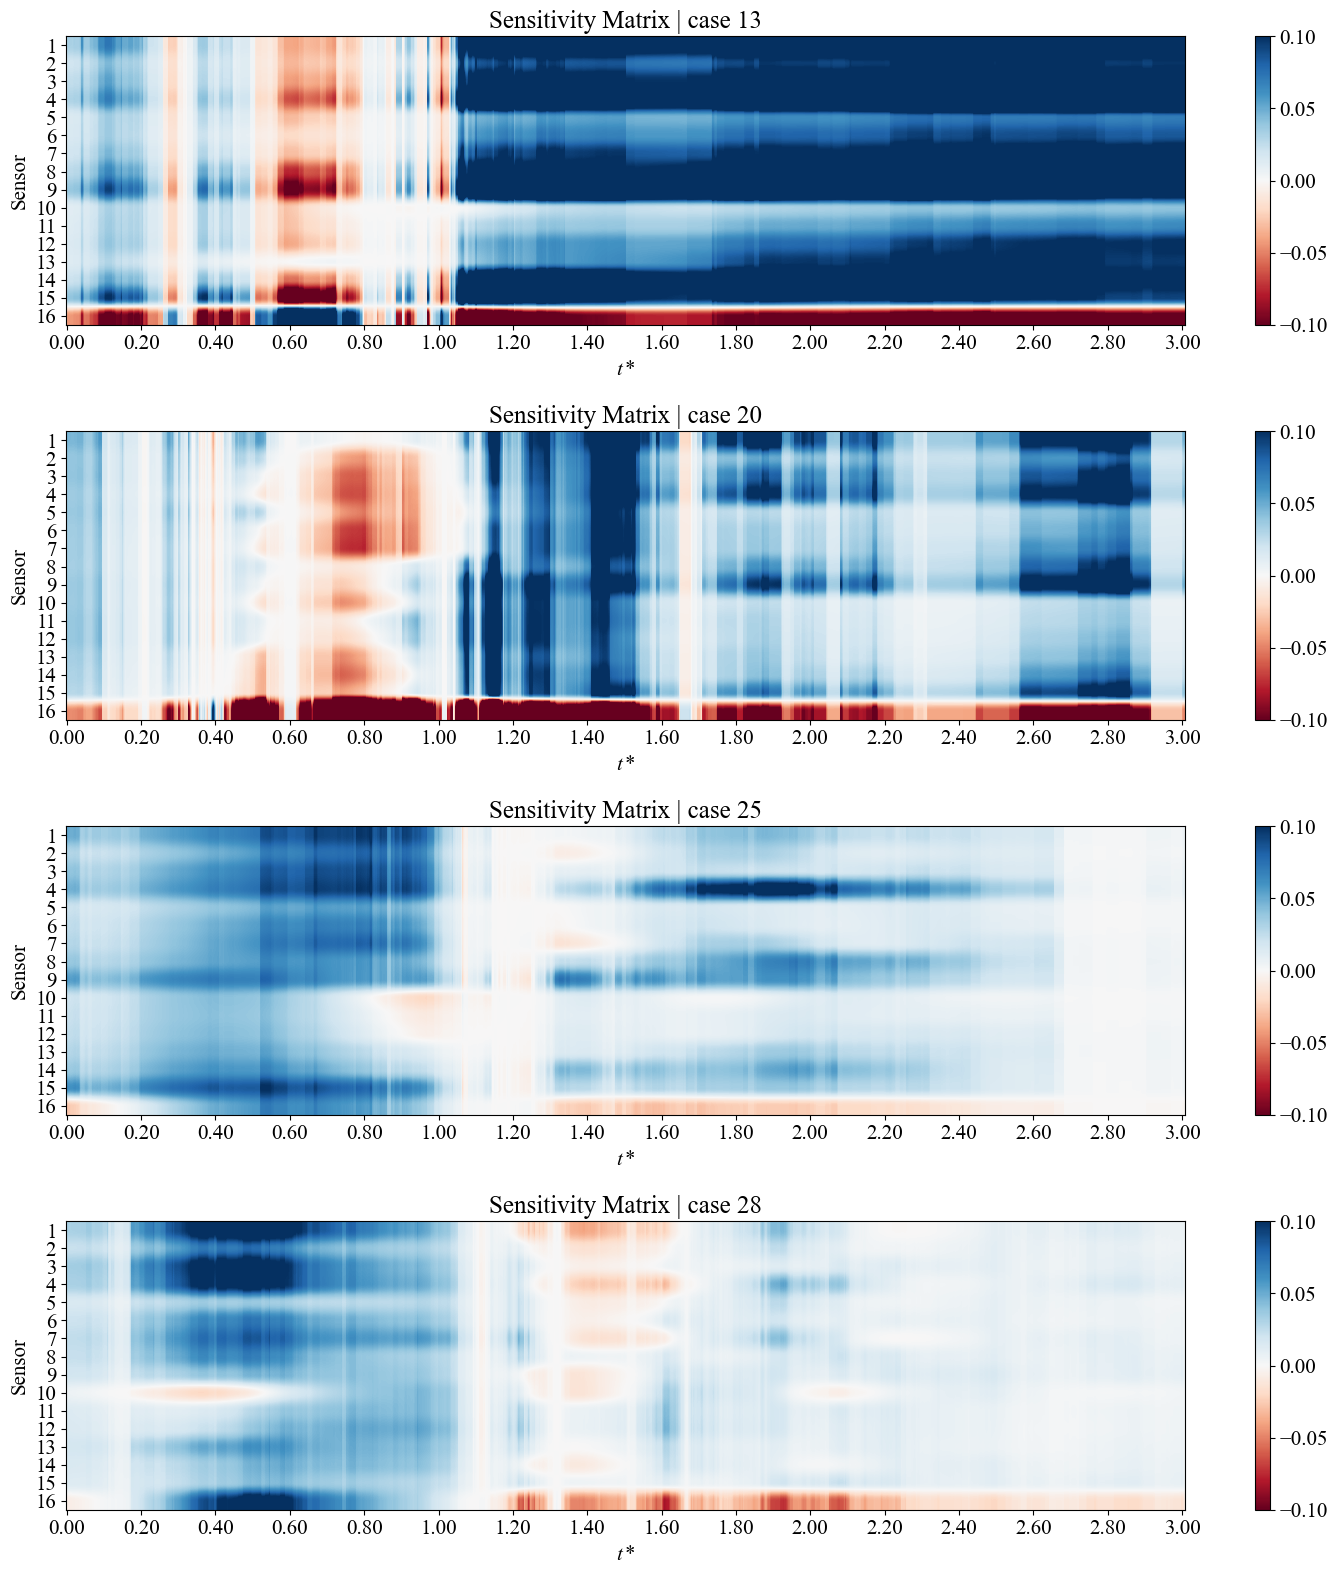

In [8]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots(4,1,figsize=(15, 4*4))

y = np.arange(16)

# Plot the heatmap
for i, case_analysis in enumerate(cases):
    cax = ax[i].imshow(grad_cam_map[i].T, cmap='RdBu', aspect='auto', vmin=-0.1, vmax=0.1)

    # Set the axis labels
    ax[i].set_xlabel('$t*$')
    ax[i].set_ylabel('Sensor')

    # Set the tick labels
    xticks = np.linspace(0, 299*3, 16)
    xticklabels = ['{:.2f}'.format(x / 299) for x in xticks]
    ax[i].set_xticks(xticks)
    ax[i].set_xticklabels(xticklabels)
    ax[i].set_yticks(y)
    ax[i].set_yticklabels(y + 1)

    # Add colorbar
    cbar = fig.colorbar(cax)

    # Set the title
    ax[i].set_title(f'Sensitivity Matrix | case {case_analysis}')

    # fig.savefig('./figure_t_0_1//sensitivity_allcase.png', dpi=350)
    # fig.savefig('./figure_t_0_1//sensitivity_allcase.svg')

plt.tight_layout(h_pad=1.2)  # Adjusts the spacing between subplots
plt.show()

# Find the average sensitivity along with time for each case matrix

In [9]:
grad_cam_map_avrg = []

for i in range(4):
    grad_cam_map_avrg.append(np.mean(np.abs(grad_cam_map[i]), axis=0))
grad_cam_map_avrg = np.concatenate(grad_cam_map_avrg).reshape(4,16)

In [10]:
grad_cam_map_avrg.shape

(4, 16)

## Plot the averaged matrix
- Average the 'absolute' matrix values with time
- Sort the matrix by ascending, and mark them with their own sensor names

### Average the matrix, no sorting

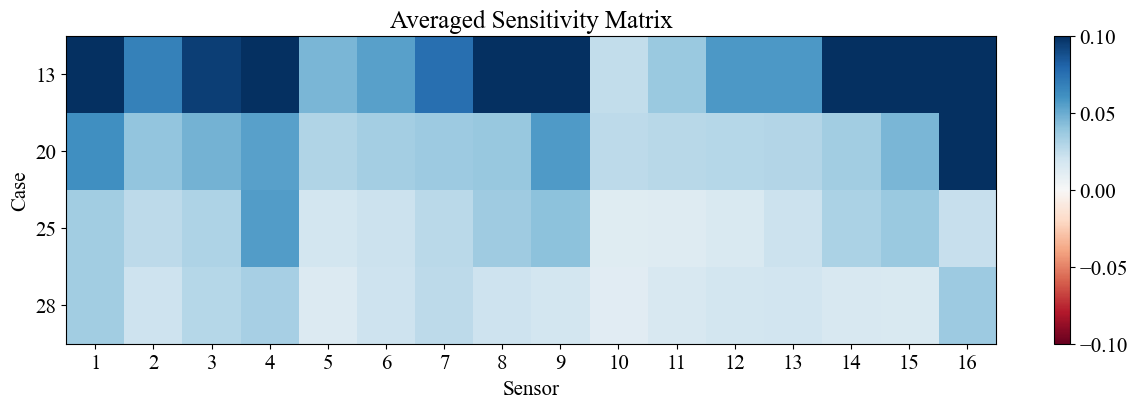

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have the matrix grad_cam_map_avrg and the list cases defined

fig, ax = plt.subplots(figsize=(15, 4))

cax = ax.imshow(grad_cam_map_avrg, cmap='RdBu', aspect='auto', vmin=-0.1, vmax=0.1)

ax.set_yticks(range(4))
ax.set_yticklabels(cases)

ax.set_xlabel('Sensor')
ax.set_ylabel('Case')

ax.set_xticks(range(16))
ax.set_xticklabels(np.arange(16)+1)

ax.set_title('Averaged Sensitivity Matrix')

# Add colorbar
cbar = fig.colorbar(cax)

# Show the plot
plt.show()


### Average the matrix while sorting by ascending

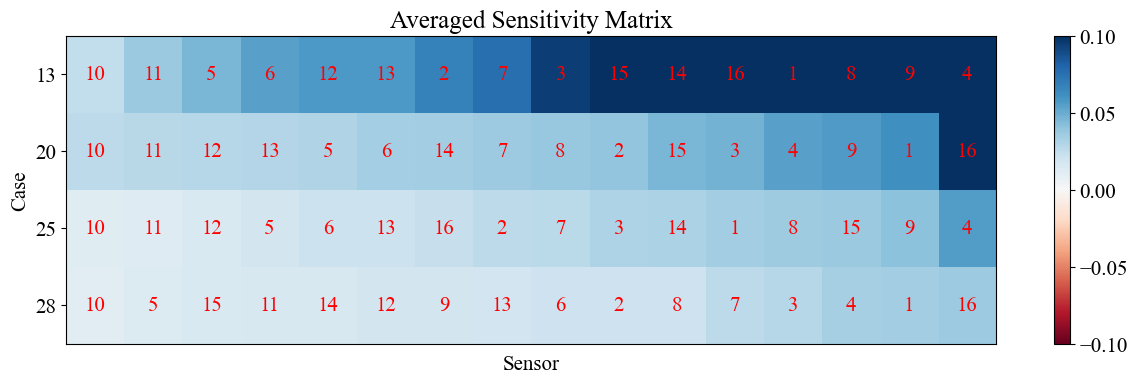

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have the matrix grad_cam_map_avrg and the list cases defined

fig, ax = plt.subplots(figsize=(15, 4))

# Sort each row in ascending order
sorted_indices = np.argsort(grad_cam_map_avrg, axis=1)
sorted_grad_cam_map_avrg = np.sort(grad_cam_map_avrg, axis=1)

cax = ax.imshow(sorted_grad_cam_map_avrg, cmap='RdBu', aspect='auto', vmin=-0.1, vmax=0.1)

# Set x tick labels for each block
for i in range(sorted_grad_cam_map_avrg.shape[1]):
    for j in range(sorted_grad_cam_map_avrg.shape[0]):
        sorted_index = sorted_indices[j, i]
        ax.text(i, j, f'{sorted_index + 1}', ha='center', va='center', color='red')  # Change text color to black

ax.set_yticks(range(4))
ax.set_yticklabels(cases)

ax.set_xlabel('Sensor')
ax.set_ylabel('Case')

ax.set_xticks([])  # Remove x tick labels

ax.set_title('Averaged Sensitivity Matrix')

# Add colorbar
cbar = fig.colorbar(cax)

# Show the plot
plt.show()

# fig.savefig('./figure_t_0_1/Averaged_Sensitivity_Matrix_sort.png', dpi=350)
# fig.savefig('./figure_t_0_1/Averaged_Sensitivity_Matrix_sort.svg')

### Average the matrix for all the four cases, no sorting

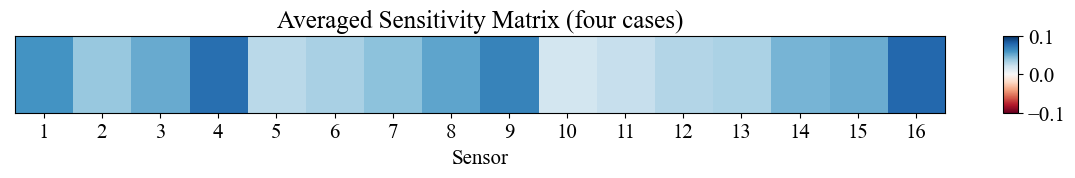

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have the matrix grad_cam_map_avrg and the list cases defined

# Average the four rows into one
averaged_row = np.mean(grad_cam_map_avrg, axis=0)

fig, ax = plt.subplots(figsize=(15, 1))

cax = ax.imshow(averaged_row[np.newaxis, :], cmap='RdBu', aspect='auto', vmin=-0.1, vmax=0.1)

ax.set_yticks([])
ax.set_xticks(range(16))
ax.set_xticklabels(np.arange(1, 17))

ax.set_xlabel('Sensor')
ax.set_title('Averaged Sensitivity Matrix (four cases)')

# Add colorbar
cbar = fig.colorbar(cax, aspect=5)

# Show the plot
plt.show()


### Average the matrix for all the four cases while sorting by ascending

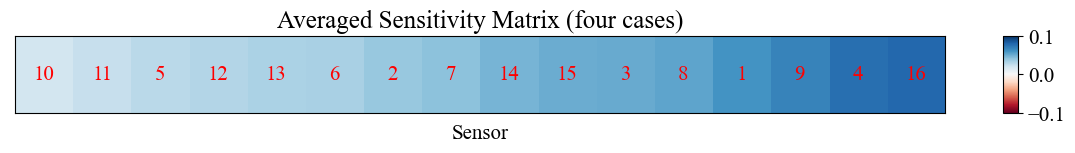

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have the matrix grad_cam_map_avrg and the list cases defined

# Average the four rows into one
averaged_row = np.mean(grad_cam_map_avrg, axis=0)

# Sort the averaged row and get the sorted indices
sorted_indices = np.argsort(averaged_row)
sorted_averaged_row = np.sort(averaged_row)

fig, ax = plt.subplots(figsize=(15, 1))

cax = ax.imshow(sorted_averaged_row[np.newaxis, :], cmap='RdBu', aspect='auto', vmin=-0.1, vmax=0.1)

# Set x tick labels for each block
for i, sorted_index in enumerate(sorted_indices):
    ax.text(i, 0, f'{sorted_index + 1}', ha='center', va='center', color='red')

ax.set_yticks([])
ax.set_xticks([])

ax.set_xlabel('Sensor')
ax.set_title('Averaged Sensitivity Matrix (four cases)')

# Add colorbar
cbar = fig.colorbar(cax, aspect=5)

# fig.savefig('./figure_t_0_1/Averaged_Sensitivity_Matrix_sort_all_case.png')
# fig.savefig('./figure_t_0_1/Averaged_Sensitivity_Matrix_sort_all_case.svg')